In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
import numpy as np
# my own files:
import Bubble_dynamics_simulation.inp_data_extractor as inp   # numeric constants and coefficents
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_O

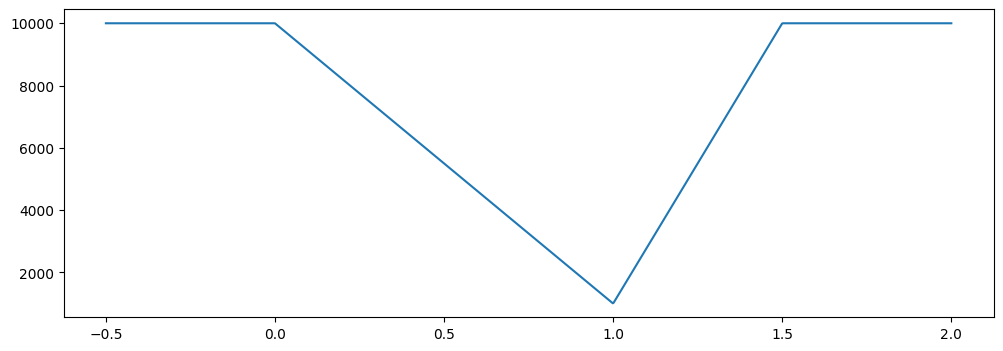

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from numba import njit   # Just In Time compiler
from numba.types import float64   # JIT types

@njit(float64(float64, float64, float64[:]))
def Excitation(t, P_amb, args):
    decay_time, increase_time, min_pressure, radius = args
    if t < 0.0:
        p_Inf = P_amb
    elif t > decay_time+increase_time:
        p_Inf = P_amb
    elif t < decay_time:
        p_Inf = P_amb - (P_amb-min_pressure) / decay_time * t
    else:
        p_Inf = min_pressure + (P_amb-min_pressure) / (increase_time) * (t-decay_time)
    return p_Inf#np.array([p_Inf, p_Inf_dot], dtype=np.float64)

def circle(t, args):
    radius, center_x, center_y = args
    return np.sqrt(radius**2 - (t-center_x)**2) + center_y

t = np.linspace(-0.5, 2.0, 1000)
args = np.array([1.0, 0.5, 1000, 0.1], dtype=np.float64); P_amb = 10000
p = [Excitation(time, P_amb, args) for time in t]
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(axisbelow=True)
ax.plot(t, p)


In [6]:
"""Import simulation"""

import numpy as np
import importlib
import matplotlib.pyplot as plt
from termcolor import colored

already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [7]:
"""Control parameters"""

cpar = de.dotdict(dict(
    ID = 0,                           # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E = 20.0e-6,                    # bubble equilibrium radius [m]
    ratio = 1.0,                      # initial radius / equilibrium radius R_0/R_E [-]
    gases=[par.index['N2'], par.index['H2']],          # indexes of species in initial bubble (list of species indexes)
    fractions=[0.25, 0.75],                  # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb = 1.0 * par.bar2Pa,         # ambient pressure [Pa]
    T_inf = 30.0 + par.absolute_zero, # ambient temperature [K]
  # Liquid parameters:
    alfa_M = 0.35,              # water accommodation coefficient [-]
    P_v = par.P_v,                    # vapour pressure [Pa]
    mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    c_L = par.c_L,                    # sound speed [m/s]
    surfactant = 1.0,                 # surfactant (surface tension modfier) [-]
  # Excitation parameters: (excitation_type = sin_impulse_flat_ends)
    p_A = -1.5*1e5,                        # [Pa]
    freq = 30.0e3,                       # [Hz]
    n = 1.0,                          # [-]
))

# Calculate pressure/temperature dependent parameters:
cpar.mu_L = de.Viscosity(cpar.T_inf)
cpar.P_v = de.VapourPressure(cpar.T_inf)

"""# Equilibrium state
p_E = cpar.P_amb + 2.0 * cpar.surfactant * par.sigma / cpar.R_E # [Pa]
V_E = 4.0 / 3.0 * cpar.R_E**3 * np.pi # [m^3]
p_gas = p_E - cpar.P_v  # [Pa]
n_gas = p_gas * V_E / (par.R_g * cpar.T_inf) # [mol]

# Expansion
R_0 = cpar.R_E * 4.5
V_0 = 4.0 / 3.0 * R_0**3 * np.pi    # [m^3]
n_H2O = cpar.P_v * V_0 / (par.R_g * cpar.T_inf) # [mol]
c_H2O = n_H2O / V_0    # [mol/m^3]
c_gas = n_gas / V_0    # [mol/m^3]
p_gas = c_gas * par.R_g * cpar.T_inf # [Pa]
cpar.min_pressure = cpar.P_amb#cpar.P_v + p_gas - 2.0 * cpar.surfactant * par.sigma / R_0"""
None

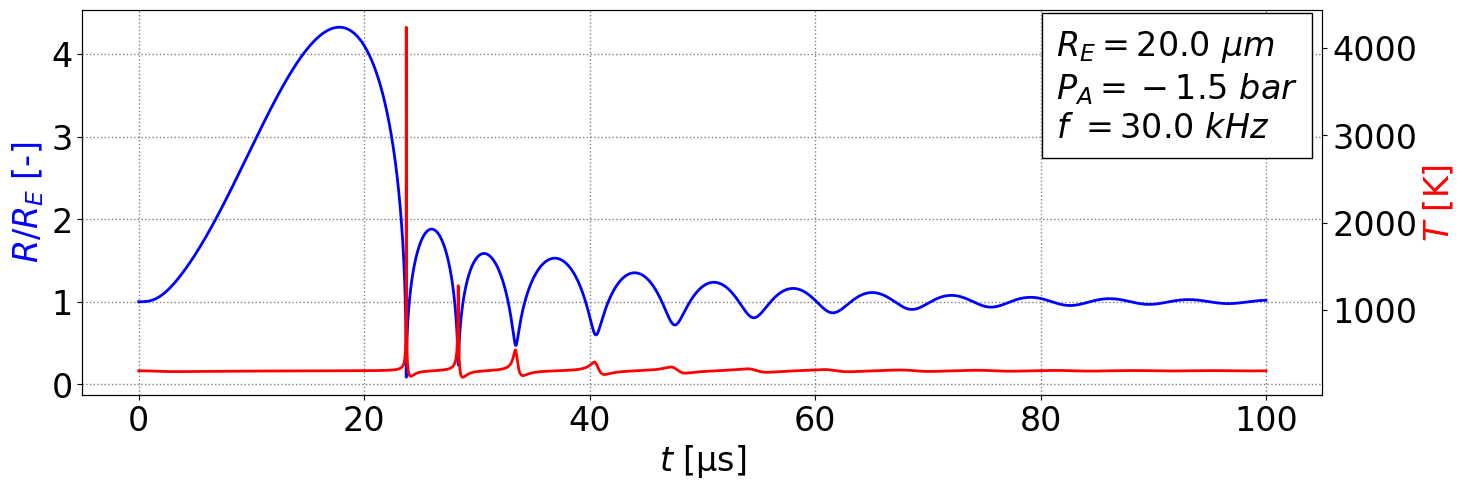

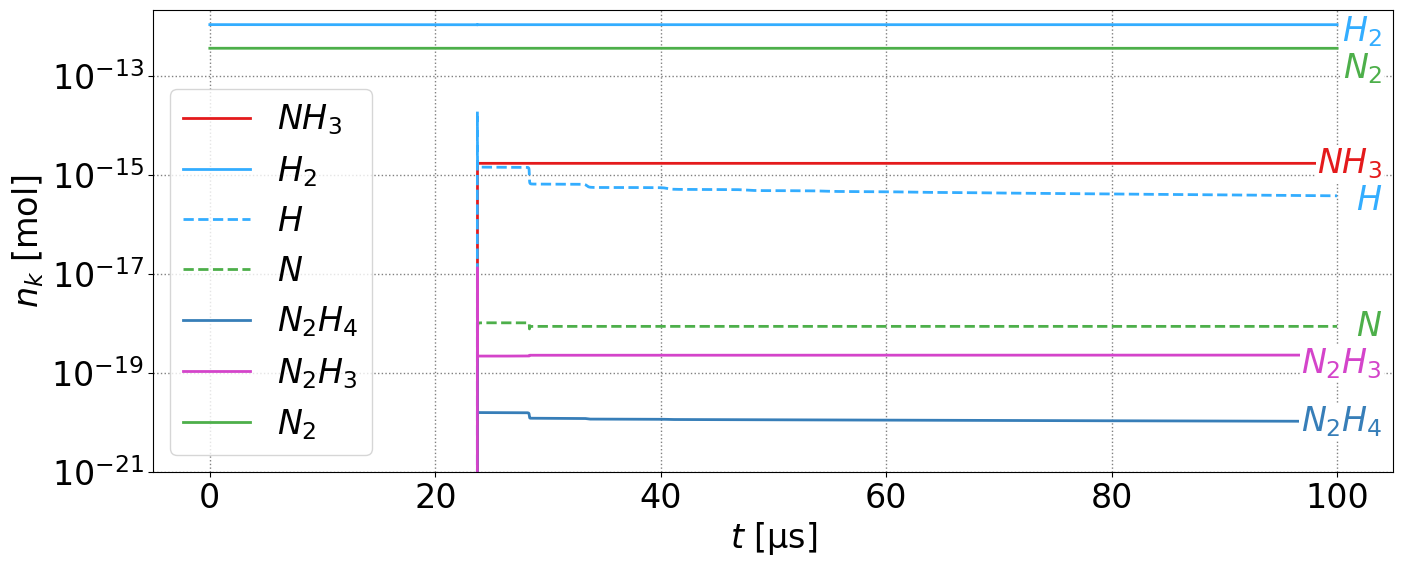

In [55]:
if True:
    num_sol, error_code, elapsed_time = de.solve(cpar, [0.0, 100e-6], 30, 300)
    data = de.get_data(cpar, num_sol, error_code, elapsed_time)
    
# Calculations
    end_index = -1
    t = num_sol.t[:end_index] * 1e6 # [us]
    R = num_sol.y[0, :end_index] # [m]
    R_dot = num_sol.y[1, :end_index] # [m/s]
    T = num_sol.y[2, :end_index] # [K]
    c = num_sol.y[3:, :end_index] # [mol/cm^3]
    V = 4.0 / 3.0 * (100.0 * R) ** 3 * np.pi # [cm^3]
    n = c * V

# plot R and T
    linewidth = 2.0
    plt.rcParams.update({'font.size': 24})
    fig1 = plt.figure(figsize=(16, 5))
    ax1 = fig1.add_subplot(axisbelow=True)
    ax2 = ax1.twinx()
    ax1.plot(t, R / cpar.R_E, color = 'b', linewidth = linewidth)
    ax2.plot(t, T, color = 'r', linewidth = linewidth, linestyle = '-')

    ax1.set_xlabel('$t$ [μs]')
    ax1.set_ylabel('$R/R_E$ [-]', color = 'b')
    ax2.set_ylabel('$T$ [K]', color = 'r')
    ax1.grid(color='grey', linestyle=':', linewidth=1)
    
# textbox with initial conditions
    text = f'''$R_E=20.0\ \mu m$
$P_A=-1.5\ bar$
$f\ =30.0\ kHz$'''

    ax2.text(
        0.98, 0.95, # coordinates
        text, transform=ax1.transAxes,
        horizontalalignment='right', verticalalignment='top', multialignment='left',
        fontsize=24, fontstyle='oblique',
        bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 10},
    )
    
# plot reactions
    fig2 = plt.figure(figsize=(16, 6))
    ax = fig2.add_subplot(axisbelow=True)

    max_mol = np.max(n, axis=1) 
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#d48044', '#33adff', '#a65628', '#f781bf', '#d444ca', '#d4ae44']
    color_index = 0
    texts = []
    for i, specie in enumerate(par.species):
        name = specie
        for digit in range(10): # turns 'H2O2' into 'H_2O_2'
            name = name.replace(str(digit), '_' + str(digit))
        if specie in ['N2', 'H2', 'NH3', 'N', 'H', 'N2H3', 'N2H4']:
            color = colors[color_index]
            color_index = color_index + 1 if color_index < len(colors) - 1 else 0
            linewidth = 2.0
            if specie in ['H', 'H2']: color = '#33adff'
            if specie in ['N', 'N2']: color = '#4daf4a'
            if specie in ['NH3']: color = '#e41a1c'
            if specie in ['N2H3']: color = '#d444ca'
            if specie in ['N2H4']: color = '#377eb8'
            linestyle = '--' if specie in ['N', 'H'] else '-'
            ax.plot(t, n[i], linewidth = linewidth, color=color, linestyle=linestyle, label = '$' + name + '$') # PLOT HERE
            texts.append((color, name, n[i, -1]))            

    # make legend
    texts.sort(key=lambda x: x[-1], reverse=True)
    last_n_final = 4.0*max_mol[par.index['H2']]
    for text in texts:
        color, name, n_final = text
        # spaceing
        if n_final < 1e-24: continue
        limit = 5.5
        if last_n_final / n_final < limit:
            n_final = last_n_final / limit
        last_n_final = n_final
        # place text
        ax.text(
            t[-1]+4,
            n_final,
            '$' + name + '$',
            color=color,
            fontsize=24,
            verticalalignment='center', horizontalalignment='right',
            bbox={'facecolor': 'white', 'pad': 1, 'linewidth': 0.0},
        )

    # plot settings
    ax.set_ylim([1e-21, 2.0*max_mol[par.index['H2']]])
    ax.set_yscale('log')
    if num_sol.t[end_index] < 1e-3:
        ax.set_xlabel('$t$ [μs]')
    else:
        ax.set_xlabel('$t$ [ms]')
    ax.set_ylabel('$n_k$ [mol]')
    ax.grid(color='grey', linestyle=':', linewidth=1)
    ax.legend()

    plt.show()

In [57]:
fig2.savefig(r'D:\BME_OneDrive\BME-7\Szakdolgozat\Poszter\time_plot2.svg', bbox_inches='tight')

succecfully solved with LSODA solver


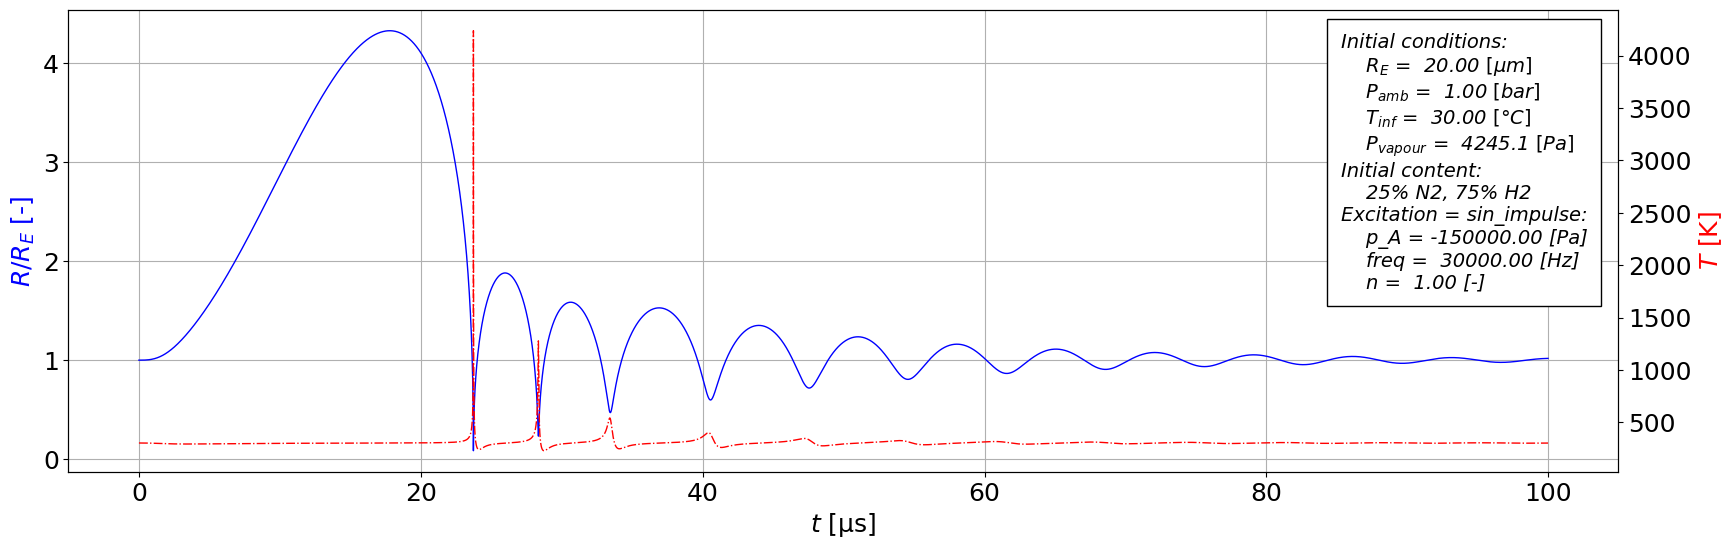

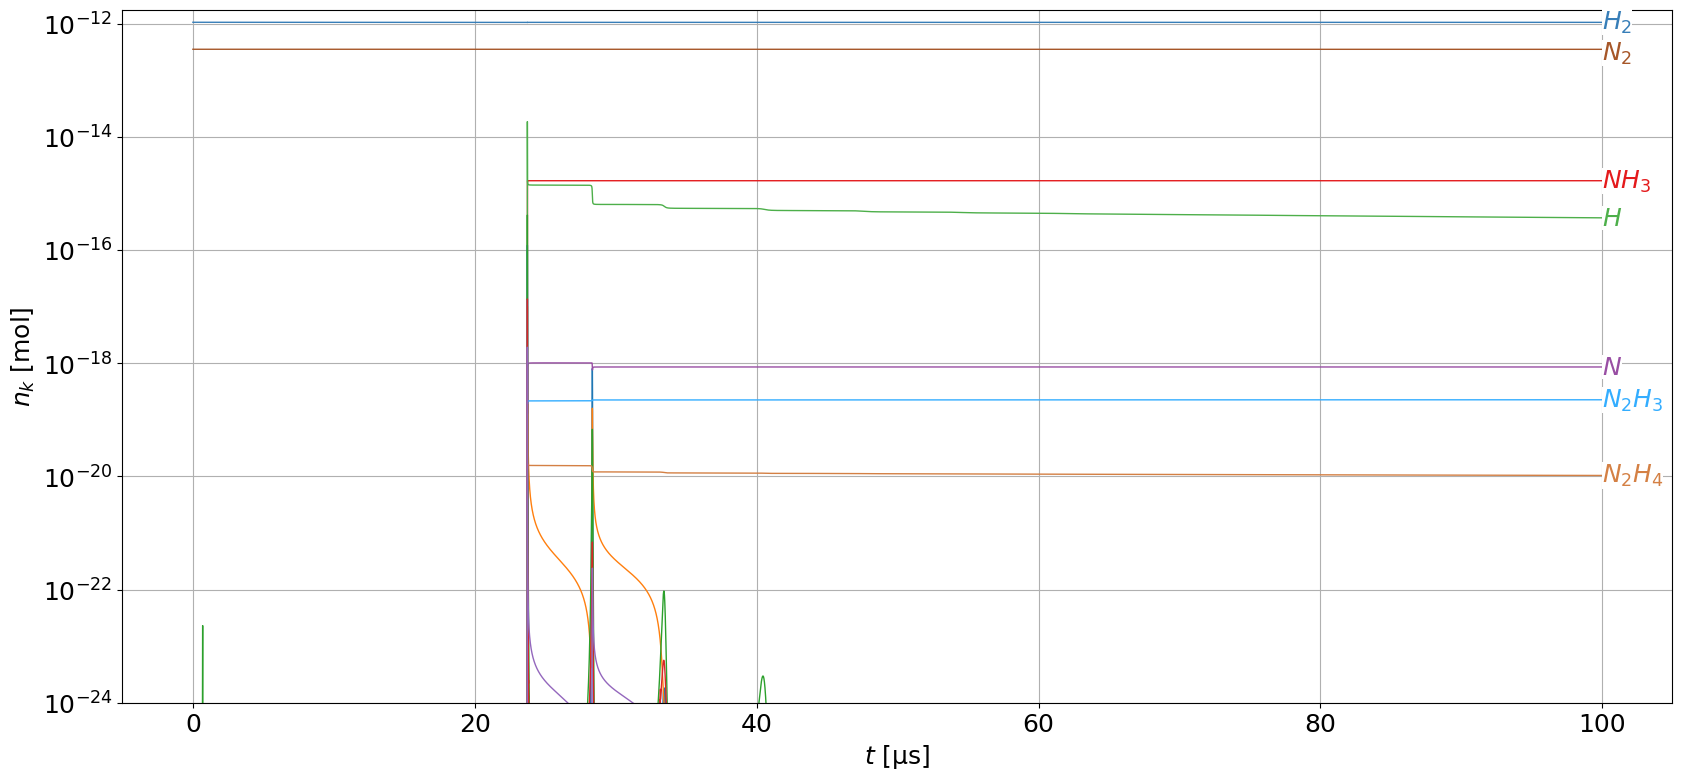

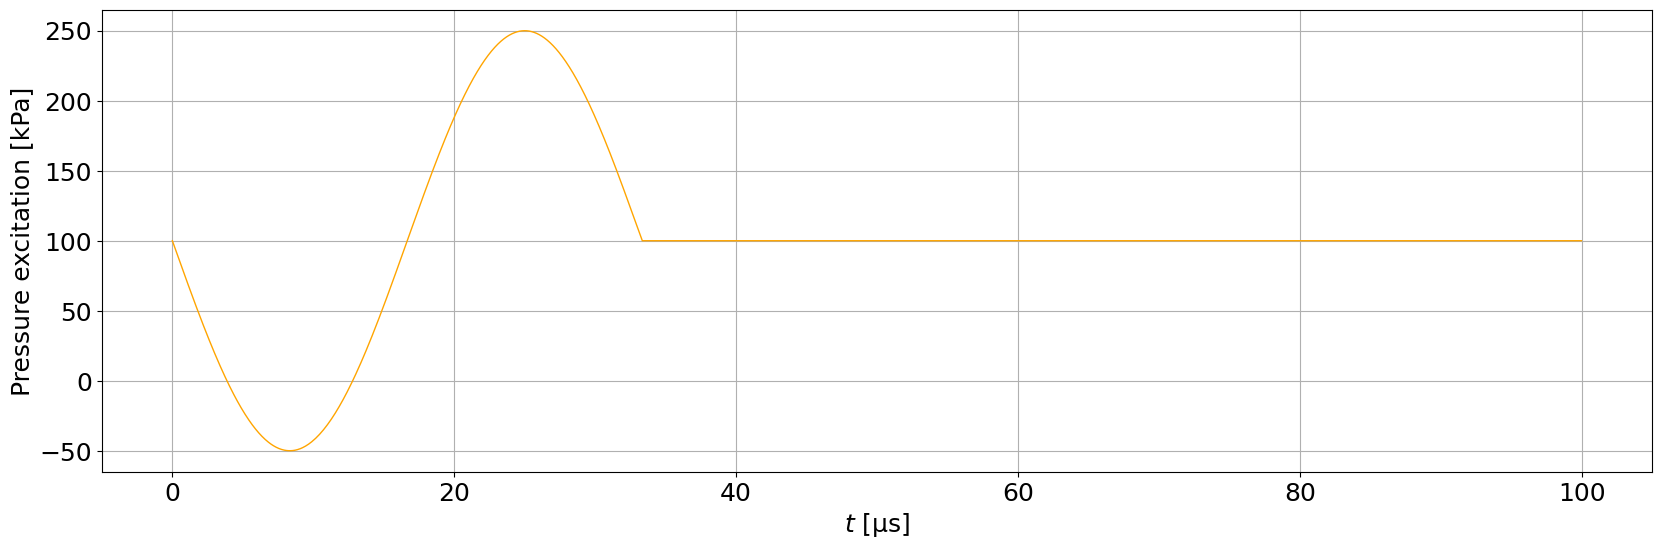

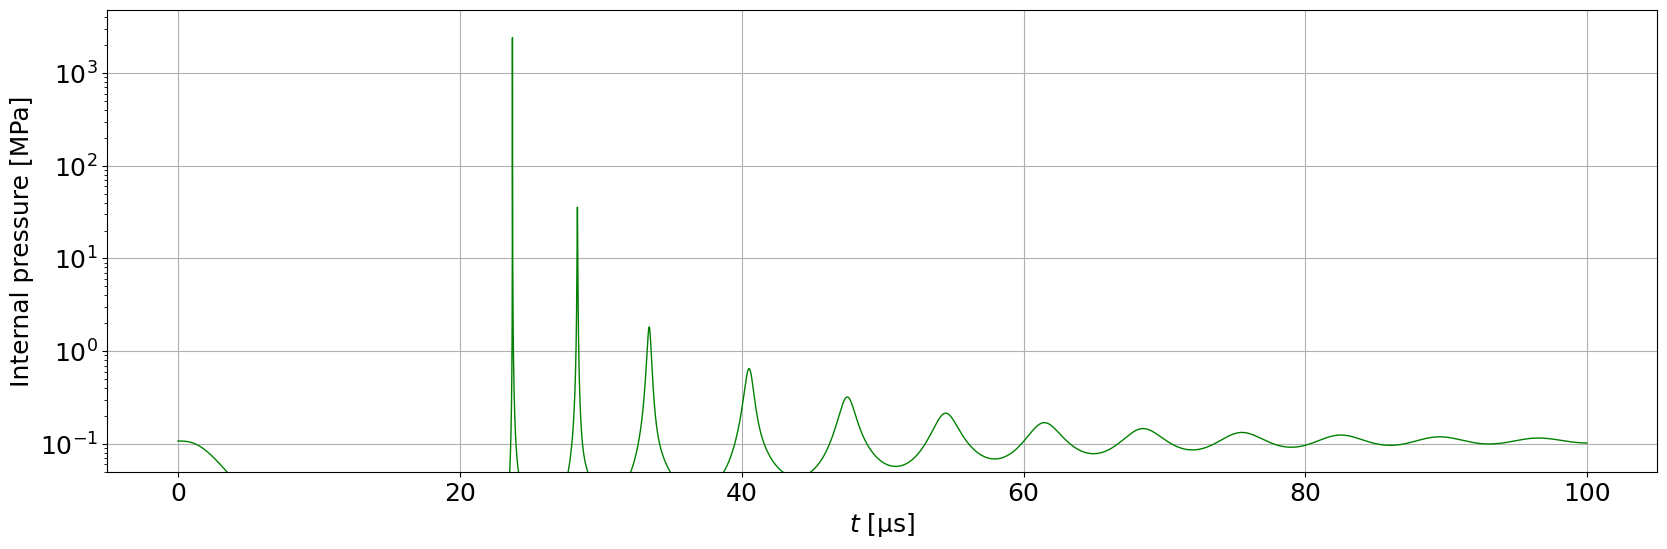

Control parameters:
    ID = 0,                                      # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  0.00002000,                           # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['N2'], par.index['H2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.25, 0.75],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  100000.00,                          # ambient pressure [Pa]
    T_inf =  303.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.3500,                            # water accommodation coefficient [-]
    P_v =  4245.13,                              # vapour pressure [Pa]
    mu_L =  0.00081486,                          # dynamic viscosity [Pa*

In [8]:
"""Plotting"""
#importlib.reload(de)   # reload changes you made
de.plot(cpar, t_int=[0.0, 3.0/cpar.freq], presentation_mode=False, plot_pressure=True, LSODA_timeout=30, Radau_timeout=0)

In [1]:
from Bubble_dynamics_simulation import inp_data_extractor as inp

path = 'Bubble_dynamics_simulation\\INP file examples\\chem_Otomo2018_without_O.inp'
inp.extract(path)

path=Bubble_dynamics_simulation\INP file examples\chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created


In [2]:
import parameters as par
print(par.model)
print(par.species)

chem_Otomo2018_without_O
['NH3' 'H2' 'H' 'NH2' 'NH' 'N' 'NNH' 'N2H4' 'N2H3' 'N2H2' 'H2NN' 'N2']


In [3]:
from Bubble_dynamics_simulation import full_bubble_model as de

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [9]:
T = 293.15 # [K]
cpar = dict(
    ID = 0,                           # ID of control parameter
  # Initial conditions:
    R_E =  100.0e-6,                  # bubble equilibrium radius [m]
    ratio =  1.00,                    # R_0/R_E [-]
    gases = [par.index['H2'], par.index['N2']], # indexes of species
    fractions = [0.75, 0.25],         # molar fractions of species
  # Ambient parameters:
    P_amb =  101325.00,               # ambient pressure [Pa]
    T_inf =  T,                       # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.35,                   # water accommodation coefficient [-]
    P_v =  de.VapourPressure(T),      # vapour pressure [Pa]
    mu_L =  de.Viscosity(T),          # dynamic viscosity [Pa*s]
    c_L =  1483.00,                   # sound speed [m/s]
    surfactant =  1.00,               # surface tension modfier [-]
  # Excitation parameters:
    p_A = -1.5e5,                     # [Pa]
    freq = 10000.0,                   # [Hz]
    n = 1.0,                          # [-]
)

In [5]:
num_sol, error_code, elapsed_time = de.solve(cpar)

In [6]:
data = de.get_data(cpar, num_sol, error_code, elapsed_time)

{'ID': 0,
 'R_E': 0.0001,
 'ratio': 1.0,
 'P_amb': 101325.0,
 'alfa_M': 0.35,
 'T_inf': 293.15,
 'P_v': 2338.339978450019,
 'mu_L': 0.0010176488244921045,
 'surfactant': 1.0,
 'gases': [1, 11],
 'fractions': [0.75, 0.25],
 'c_L': 1483.0,
 'p_A': -150000.0,
 'freq': 10000.0,
 'n': 1.0,
 'error_code': 0,
 'elapsed_time': 1.1870155334472656,
 'steps': 13182,
 'collapse_time': 7.620771465693553e-05,
 'T_max': 3631.2466043859313,
 'x_initial': array([1.00000000e-04, 0.00000000e+00, 2.93150000e+02, 0.00000000e+00,
        3.16213209e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.05404403e-05, 0.00000000e+00]),
 'x_final': array([ 9.99946833e-05, -1.72152956e-12,  2.93150000e+02,  6.71353202e-09,
         3.16163068e-05,  1.00756836e-12,  6.24928914e-26,  5.99293945e-23,
         3.52948736e-12,  2.91933474e-23,  3.37800084e-16,  7.95204496e-13,
         1.63831959e-19,  1.8

In [10]:
import importlib
importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


<module 'Bubble_dynamics_simulation.full_bubble_model' from 'd:\\parameter_studies\\Bubble_dynamics_simulation\\full_bubble_model.py'>

succecfully solved with LSODA solver


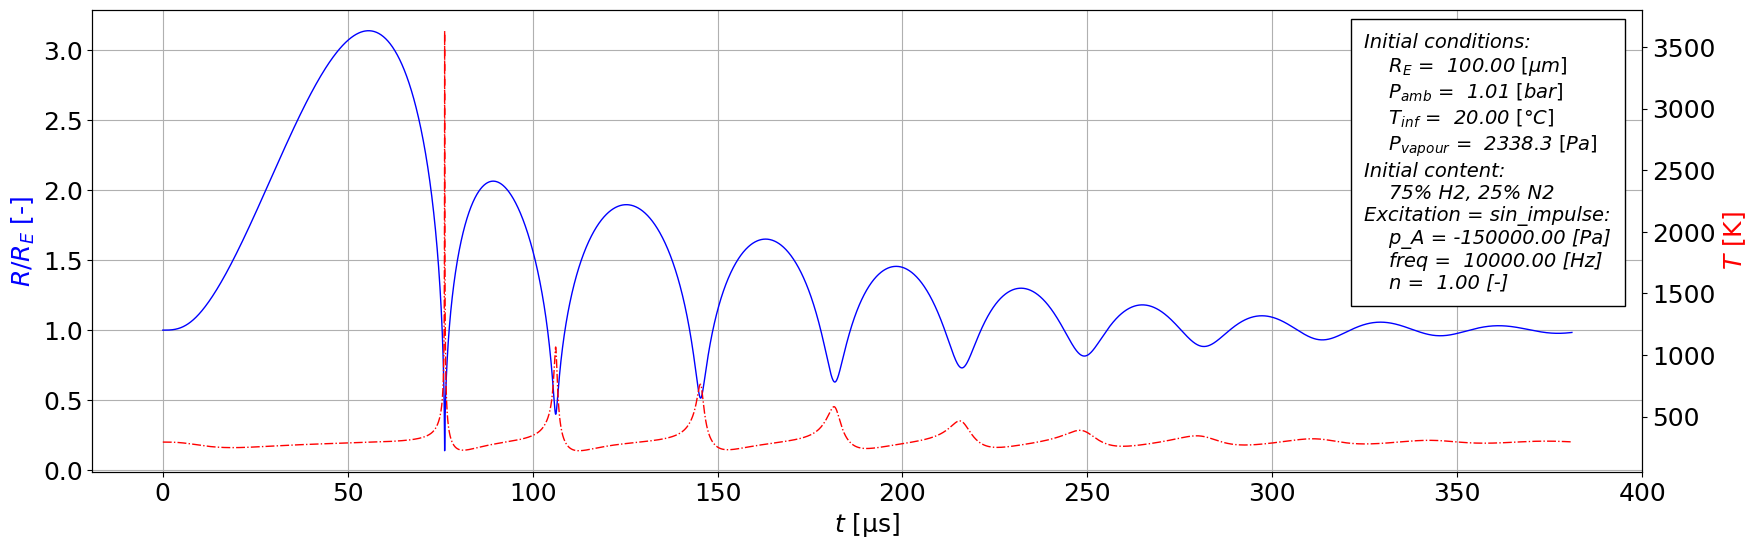

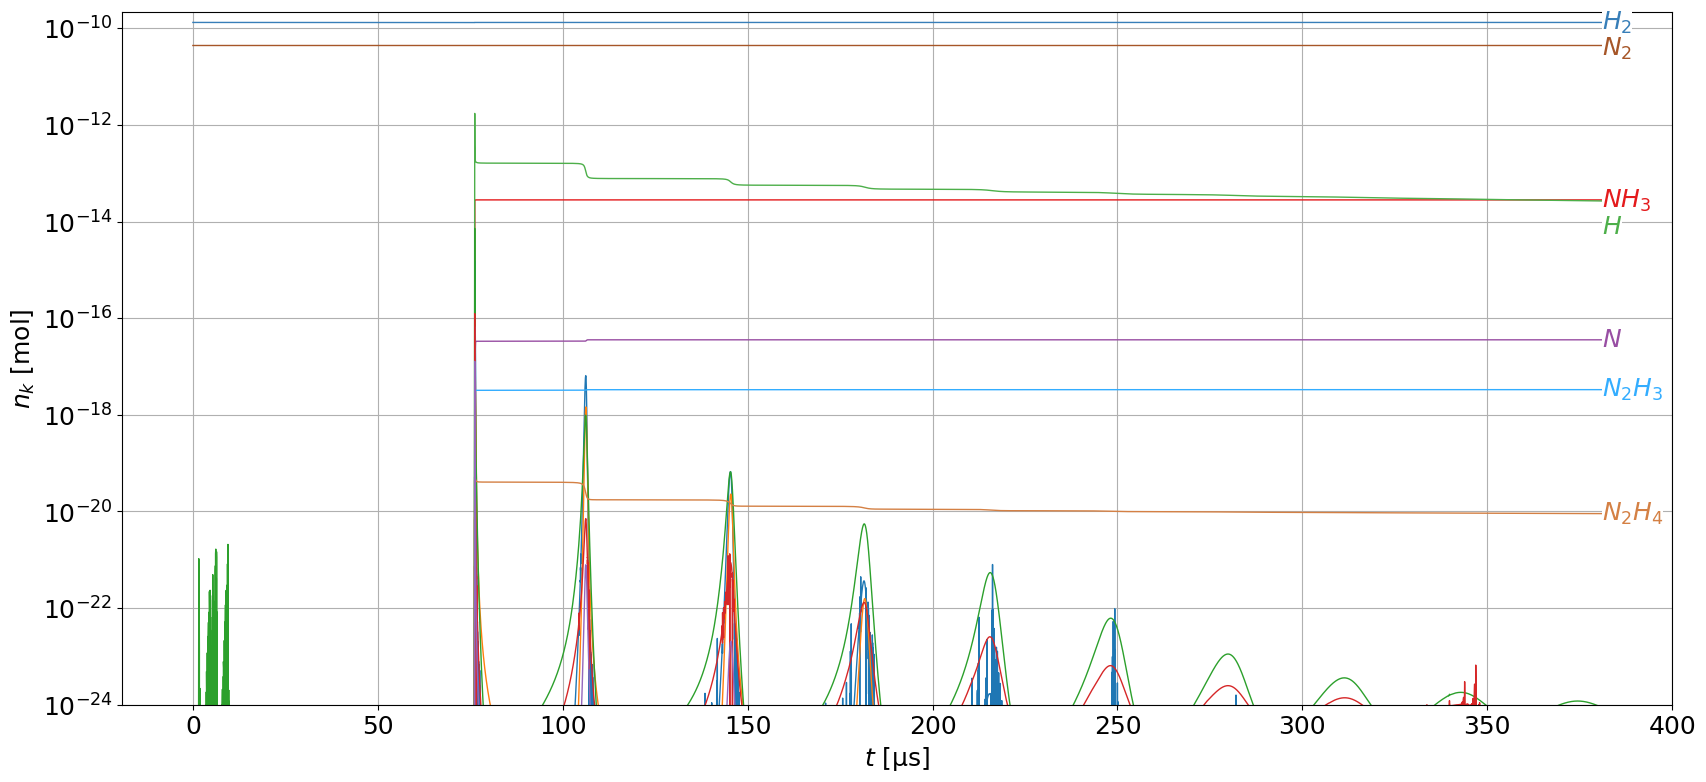

Control parameters:
    ID = 0,                                      # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  0.00010000,                           # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['H2'], par.index['N2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.75, 0.25],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  101325.00,                          # ambient pressure [Pa]
    T_inf =  293.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.3500,                            # water accommodation coefficient [-]
    P_v =  2338.34,                              # vapour pressure [Pa]
    mu_L =  0.0010,                              # dynamic viscosity [Pa*

In [10]:
de.plot(cpar)